In [1]:
from torchvision.datasets import CIFAR10
from torchvision.transforms.functional import to_tensor
import torch


data = CIFAR10(root="/home/nora/Data/cifar10", download=True)
images, labels = zip(*data)

X = torch.stack(list(map(to_tensor, images))).cuda()
Y = torch.tensor(labels).cuda()

# Shuffle deterministically
rng = torch.Generator(device=X.device).manual_seed(42)
perm = torch.randperm(len(X), generator=rng, device=X.device)
X, Y = X[perm], Y[perm]

X_vec = X.view(X.shape[0], -1)
k = int(Y.max()) + 1

test_size = 1024

X_vec_train = X_vec[:-test_size]
X_vec_test = X_vec[-test_size:]

X_train, X_test = X[:-test_size], X[-test_size:]
Y_train, Y_test = Y[:-test_size], Y[-test_size:]

Files already downloaded and verified


In [2]:
state = torch.load("/home/nora/Data/erasers.pt")
oleace = state['oleace']
qleace = state['qleace']

In [13]:
import torch
from torch import Tensor, optim

from mdl.probe import Probe
from mlp_mixer_pytorch import MLPMixer


class MixerProbe(Probe):
    """Multi-layer perceptron with ResNet architecture."""

    def __init__(
        self,
        num_features: int,
        num_classes: int = 2,
        device: str | torch.device = "cpu",
        dtype: torch.dtype | None = None,
    ):
        super().__init__(num_features, num_classes, device, dtype)

        self.mixer = MLPMixer(
            image_size=32,
            channels=3,
            patch_size=4,
            dim=768,
            depth=16,
            num_classes=k,
        ).to(dtype=dtype).to(device=device)

    def forward(self, x: Tensor) -> Tensor:
        return self.mixer(x).squeeze(-1)

    def build_optimizer(self) -> optim.Optimizer:
        return optim.SGD(
            self.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4,
        )


class VitProbe(Probe):
    def __init__(
        self,
        num_classes: int = 2,
        device: str | torch.device = "cpu",
        dtype: torch.dtype | None = None,
    ):
        super().__init__(3, num_classes, device, dtype)

        from vit_pytorch import ViT

        self.vit = ViT(
            channels=3,
            depth=6,
            dim=512,
            dropout=0.1,
            #emb_dropout=0.1,
            heads=8,
            image_size=32,
            mlp_dim=1024,
            num_classes=k,
            patch_size=4,
        ).to(dtype=dtype).to(device=device)

    def forward(self, x: Tensor) -> Tensor:
        return self.vit(x).squeeze(-1)

    def build_optimizer(self) -> optim.Optimizer:
        # Implicitly does learning rate warmup in a principled way
        #return optim.SGD(self.parameters(), lr=0.005, momentum=0.9, weight_decay=0.1)
        return optim.Adam(self.parameters())

In [4]:
from torchvision.transforms.v2 import RandAugment, AutoAugment
import torchvision as tv

image_size = X.shape[-1]
padding = round(image_size * 0.125)

augmentor = tv.transforms.Compose(
    [
        tv.transforms.RandomCrop(image_size, padding=padding),
        tv.transforms.RandomHorizontalFlip(),
        #tv.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        # AutoAugment()
    ]
)

/home/nora/miniconda3/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/nora/miniconda3/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have 

In [7]:
from mdl import VisionProbe

probe = VisionProbe(k, device=X.device)
probe.fit(X_train, Y_train, reduce_lr_on_plateau=False, max_epochs=200, verbose=True, early_stop_epochs=10, augment=augmentor)

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

/home/nora/miniconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


KeyboardInterrupt: 

In [12]:
probe.accuracy(X_test.bfloat16(), Y_test, 128)

0.8466796875

In [7]:
def to_bytes(x):
    return x.mul(255).byte()

def to_float(x):
    return x.float().div(255)


In [14]:
from torchvision.transforms.functional import to_pil_image

with torch.autocast("cuda"):
    vit = VitProbe(device=X.device)
    vit.fit(X_train, Y_train, verbose=True, reduce_lr_on_plateau=True, max_epochs=200, early_stop_epochs=50, augment=augmentor, batch_size=100)

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

In [16]:
vit.accuracy(X_test, Y_test, 128)

0.505859375

In [64]:
from mdl import Sweep, VisionProbe


sweep = Sweep(
    X_vec.shape[1], k, device=X.device, dtype=torch.bfloat16,
    num_chunks=10,
    # probe_kwargs=dict(hidden_size=768, num_layers=8),
    probe_cls=VisionProbe,
)
results = [
    sweep.run(X_train.bfloat16(), Y_train, seed=i, augment=augmentor, reduce_lr_on_plateau=False)
    for i in range(5)
]
results_ = [
    sweep.run(
        X_train.bfloat16(), Y_train, seed=i,
        transform=lambda x, y: qleace.eraser(x.flatten(1), y).reshape_as(x),
        augment=augmentor,
    )
    for i in range(5)
]

  0%|          | 0/9 [00:00<?, ?scales/s]

  0%|          | 0/9 [00:00<?, ?scales/s]

KeyboardInterrupt: 

In [4]:
results_linear_ = [
    sweep.run(
        X_train.bfloat16(), Y_train, seed=i,
        transform=lambda x, y: oleace.eraser(x.flatten(1), y),
        augment=augmentor,
    )
    for i in range(5)
]

  0%|          | 0/9 [00:00<?, ?scales/s]

  0%|          | 0/9 [00:00<?, ?scales/s]

  0%|          | 0/9 [00:00<?, ?scales/s]

  0%|          | 0/9 [00:00<?, ?scales/s]

  0%|          | 0/9 [00:00<?, ?scales/s]

  0%|          | 0/9 [00:00<?, ?scales/s]

  0%|          | 0/9 [00:00<?, ?scales/s]

  0%|          | 0/9 [00:00<?, ?scales/s]

  0%|          | 0/9 [00:00<?, ?scales/s]

  0%|          | 0/9 [00:00<?, ?scales/s]

In [5]:
import pickle

with open("/home/nora/Data/cifar-results/mlp16.pkl", "wb") as f:
    pickle.dump({
        'results': results,
        'results_': results_,
        'results_linear_': results_linear_,
    }, f)

In [6]:
import numpy as np

curve = np.median([res.ce_curve for res in results], axis=0)
curve_ = np.median([res.ce_curve for res in results_], axis=0)
curve_linear_ = np.median([res.ce_curve for res in results_linear_], axis=0)

In [17]:
sum(p.numel() for p in mixer.parameters())

10081034

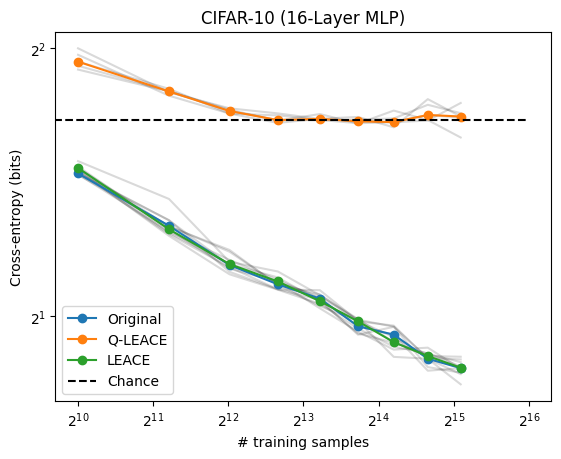

In [8]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.plot(results[i].sample_sizes[:-1], results[i].ce_curve, alpha=0.15, c="black")
    plt.plot(results[i].sample_sizes[:-1], results_[i].ce_curve, alpha=0.15, c="black")
    plt.plot(results[i].sample_sizes[:-1], results_linear_[i].ce_curve, alpha=0.15, c="black")

plt.plot(results[0].sample_sizes[:-1], curve, label="Original", marker="o")
plt.plot(results[0].sample_sizes[:-1], curve_, label="Q-LEACE", marker="o")
plt.plot(results[0].sample_sizes[:-1], curve_linear_, label="LEACE", marker="o")

plt.hlines(np.log2(10), 0, 2 ** 16, label="Chance", linestyle="--", color="black")
plt.legend()
plt.xscale("log", base=2)
plt.xlabel("# training samples")
plt.ylabel("Cross-entropy (bits)")
plt.title("CIFAR-10 (16-Layer MLP)")
plt.yscale("log", base=2)

In [11]:
resnet = tv.models.resnet18(pretrained=True)

/home/nora/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nora/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
resnet.layer1[0]

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
from torchvision.models.resnet import BasicBlock

In [ ]:
from torch import nn

class MlpBlock(nn.Module):
    def __init__(
        self, in_features: int, out_features: int, device = None, dtype = None
    ):
        super().__init__()

        self.linear1 = nn.Linear(
            in_features, out_features, bias=False, device=device, dtype=dtype
        )
        self.linear2 = nn.Linear(
            out_features, out_features, bias=False, device=device, dtype=dtype
        )
        self.bn1 = nn.BatchNorm1d(
            in_features, device=device, dtype=dtype
        )
        self.bn2 = nn.BatchNorm1d(
            out_features, device=device, dtype=dtype
        )
        self.downsample = nn.Linear(
            in_features, out_features, bias=False, device=device, dtype=dtype
        ) if in_features != out_features else None

    def forward(self, x):
        identity = x
    
        out = self.linear1(x)
        out = self.bn1(out)
        out = nn.functional.relu(out)

        out = self.linear2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(identity)

        out += identity
        out = nn.functional.relu(out)

        return out